10/2/2018
====

>### David advised me to use BP-RP and BP-DDO51 for my colors and to try running the linear model again on the Cannon.

In [1]:
# Import libraries and modules
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# Import the calibration data
cat = fits.getdata('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits')
labelled_set = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits')

#Filter out bad MgH values
ind = np.where(labelled_set['MGH']<10)
labelled_set = labelled_set[ind]
cat = cat[ind]

#columns to remove from data
#Note: I had to temporarily remove logg from labelled_set.
#The Cannon will not allow stellar parameters to exceed number of colors.
rmclm = [i for i in labelled_set.colnames if i!= 'MGH' and i!= 'TEFF']
labelled_set.remove_columns(rmclm)
len(labelled_set)

4397

In [47]:
cat = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits')
cat.info

<Table length=4408>
         name          dtype  shape  n_bad
--------------------- ------- ------ -----
            APSTAR_ID   str37            0
            TARGET_ID   str23            0
            ASPCAP_ID   str39            0
                 FILE   str34            0
            APOGEE_ID   str18            0
          LOCATION_ID   int16            0
                FIELD   str16            0
                    J float32            0
                J_ERR float32            0
                    H float32            0
                H_ERR float32            0
                    K float32            0
                K_ERR float32            0
                   RA float64            0
                  DEC float64            0
                 GLON float64            0
                 GLAT float64            0
              AK_TARG float32            0
       AK_TARG_METHOD   str17            0
              AK_WISE float32           26
       APOGEE_TARGET1   int32     

In [48]:
#Make new array for normalized_flux (photometric data)
#THIS TIME WITH DIFFERENT COLORS!
#I edited the line below from this mornint. The colors were incorrect.
normalized_flux = np.array([[cat['BP'][i]-cat['RP'][i],cat['DDO51'][i]-cat['RP'][i]] for i in range(0,4397)])
np.info(normalized_flux)
###normalized_flux

class:  ndarray
shape:  (4397, 2)
strides:  (8, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x22d01121da0
byteorder:  little
byteswap:  False
type: float32


In [49]:
normalized_ivar = normalized_flux.copy()*0 + 1e4

#A 1st order polynomial will be constructed
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + MGH'

In [50]:
# Train the model
nr_theta, nr_s2, nr_metadata = model.train()  
# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-02 19:16:34,869 [INFO] Training 2-label CannonModel with 4397 stars and 2 pixels/star
2018-10-02 19:16:34,934 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[==                                                                                                  ] 100% (0s)                           


2018-10-02 19:16:35,048 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-02 19:16:35,050 [INFO] Running test step on 4397 spectra


[======================================================================================================] 100% (22s)                                


TEFF bias = 46.966 scatter = 997.881
MGH bias = -0.308 scatter = 5.371


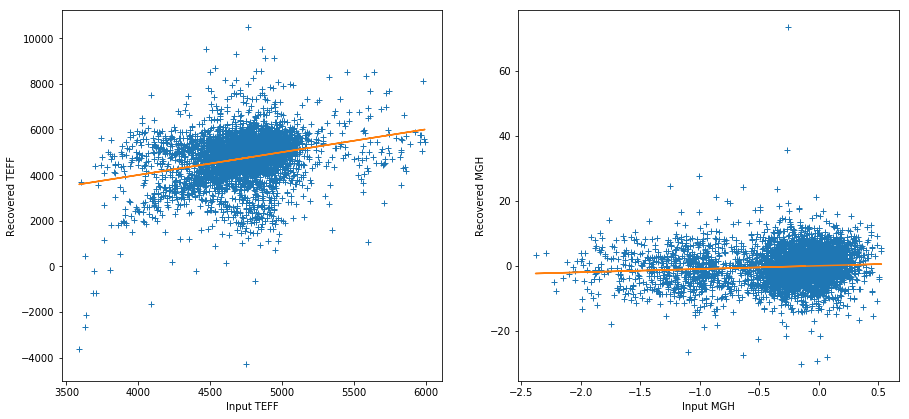

In [51]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
for i in range(0, 2):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    print(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]) )
    

In [31]:
model.vectorizer.label_names

('TEFF', 'MGH')

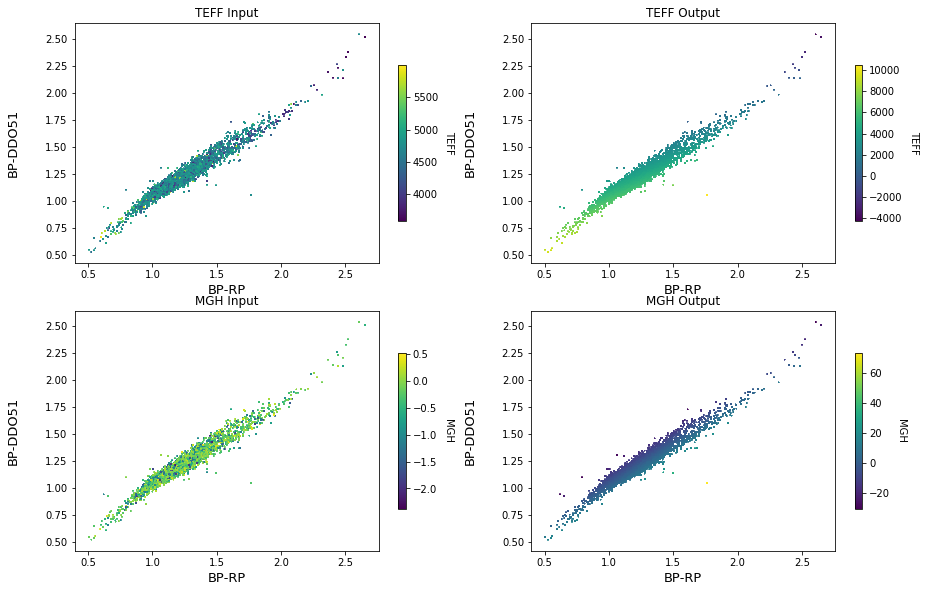

In [52]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,2):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)

    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    
plt.show()

>### Now I'll try to include logg and Teff rather than MgH.

In [35]:
# Import the calibration data
cat = fits.getdata('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits')
labelled_set = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits')

#Filter out bad MgH values
ind = np.where(labelled_set['MGH']<10)
labelled_set = labelled_set[ind]
cat = cat[ind]

#columns to remove from data
#Note: I had to temporarily remove logg from labelled_set.
#The Cannon will not allow stellar parameters to exceed number of colors.
rmclm = [i for i in labelled_set.colnames if i!= 'LOGG' and i!= 'TEFF']
labelled_set.remove_columns(rmclm)
len(labelled_set)

4397

In [36]:
#Make new array for normalized_flux (photometric data)
#THIS TIME WITH DIFFERENT COLORS!
normalized_flux = np.array([[cat['BP'][i]-cat['RP'][i],cat['BP'][i]-cat['DDO51'][i]] for i in range(0,4397)])
np.info(normalized_flux)
###normalized_flux

class:  ndarray
shape:  (4397, 2)
strides:  (8, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x22d1e8cdfc0
byteorder:  little
byteswap:  False
type: float32


In [37]:
normalized_ivar = normalized_flux.copy()*0 + 1e4

#A 1st order polynomial will be constructed
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG'

In [38]:
# Train the model
nr_theta, nr_s2, nr_metadata = model.train()  
# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-02 14:27:05,889 [INFO] Training 2-label CannonModel with 4397 stars and 2 pixels/star
2018-10-02 14:27:05,915 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[==                                                                                                  ] 100% (0s)                           


2018-10-02 14:27:05,962 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-02 14:27:05,964 [INFO] Running test step on 4397 spectra


[======================================================================================================] 100% (20s)                                


TEFF bias = 18.640 scatter = 168.524
LOGG bias = -0.097 scatter = 0.954


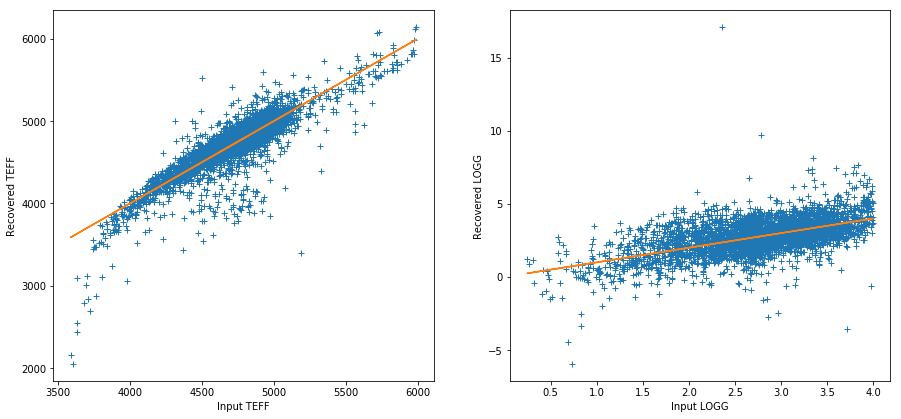

In [39]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
for i in range(0, 2):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    print(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]) )
    

In [40]:
model.vectorizer.label_names

('TEFF', 'LOGG')

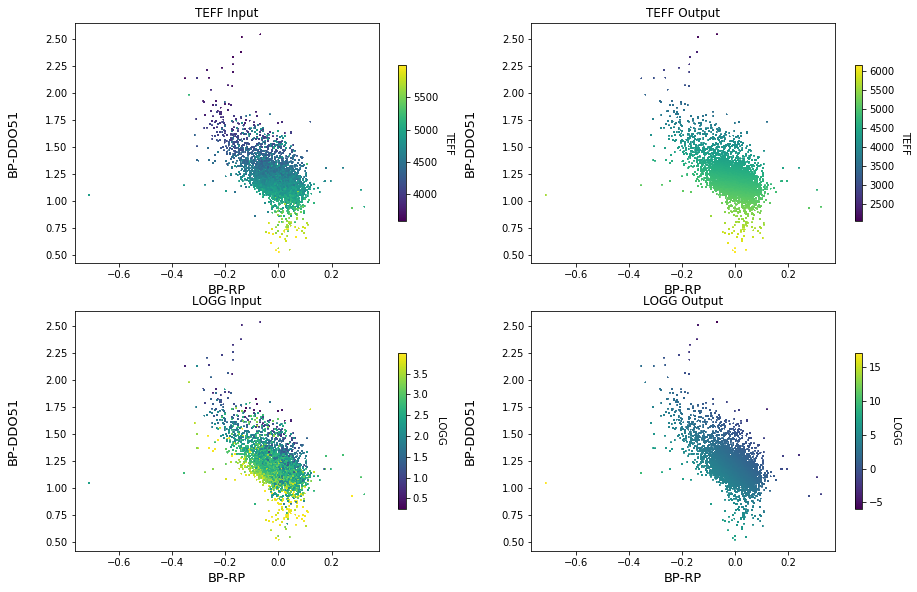

In [41]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,2):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)

    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    
plt.show()

>### Below I make changes to the Girardi data and then input it into the Cannon.  I cut out the dwarfs with a logg<3.8 cut.

In [194]:
# Import functions
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
#Import the calibration data
cat = fits.getdata('WISE_ddo51_isochrone_5e9_range.fits')
labelled_set = Table.read('WISE_ddo51_isochrone_5e9_range.fits')
###labelled_set.info

#Columns to remove from data
#Keep only logg and logTe for now
rmclm = [i for i in labelled_set.colnames if i!= 'logg' and i!= 'logTe']
labelled_set.remove_columns(rmclm)
labelled_set

#Filter out dwarfs
ind = np.where(labelled_set['logg']>3.8)
labelled_set = labelled_set[ind]
cat = cat[ind]
len(cat)

19434

In [43]:
#Make new array for normalized_flux (photometric data)
#ALLWISE combined with DDO51 photometry
normalized_flux = np.array([[cat['W2mag'][i]-cat['W1mag'][i],cat['W2mag'][i]-cat['W1mag'][i],cat['DDO51_finfmag'][i]-cat['W1mag'][i]] for i in range(0,75855)])

IndexError: index 19434 is out of bounds for axis 0 with size 19434

In [12]:
normalized_ivar = normalized_flux.copy()*0 + 1e4
#A 1st order polynomial will be constructed
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + logTe + logg'

In [13]:
# Train the model
nr_theta, nr_s2, nr_metadata = model.train()  
# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-02 14:11:27,074 [INFO] Training 2-label CannonModel with 75855 stars and 3 pixels/star
2018-10-02 14:11:27,111 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-02 14:11:27,312 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-02 14:11:27,315 [INFO] Running test step on 75855 spectra


[====================================================================================================] 100% (313s)                                 


logTe bias = -0.009 scatter = 0.057
logg bias = 0.998 scatter = 4.636


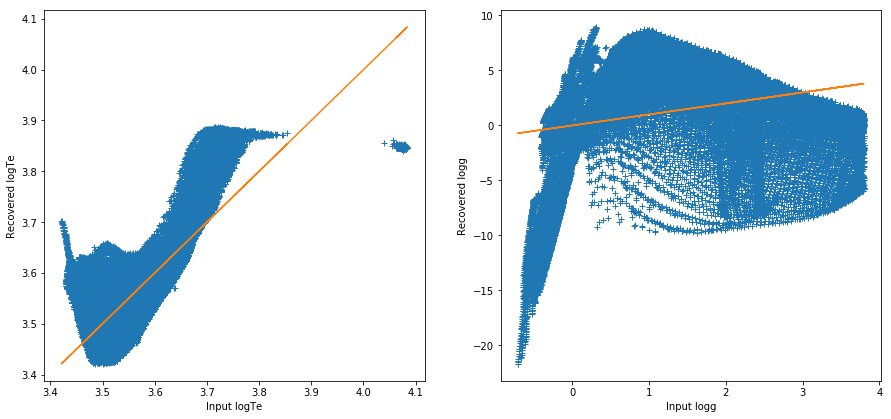

In [14]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
for i in range(0,2):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    print(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]) )
    

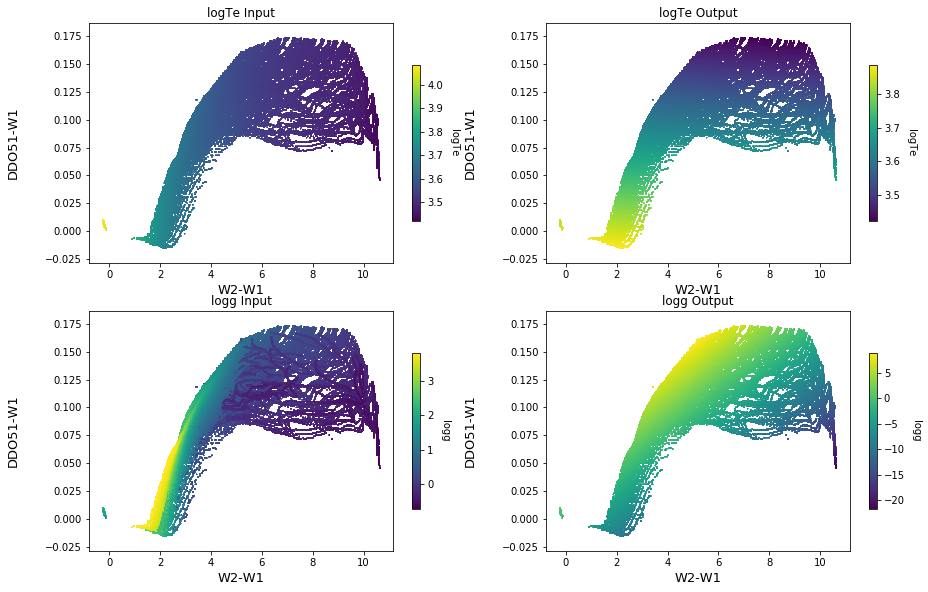

In [15]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,2]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,2):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('W2-W1',fontsize=13)
    plt.ylabel('DDO51-W1',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)

    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('W2-W1',fontsize=13)
    plt.ylabel('DDO51-W1',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    
plt.show()

>### Received feedback during group meeting.  The following changes will be made to the Cannon training with the calibration data:
 - Make a temperature cut in Girardi (keep <6000 K)
 - Insert variance into calibration data
 - Use J-RP in calibration data
 - Use the same color scheme in color bars for input vs. output

In [2]:
# Import libraries and modules
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Import the calibration data
cat = fits.getdata('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')
labelled_set = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')

#Filter out bad MgH values
ind = np.where(labelled_set['MGH']<10)
labelled_set = labelled_set[ind]
cat = cat[ind]

#columns to remove from data
#Note: I had to temporarily remove logg from labelled_set.
#The Cannon will not allow stellar parameters to exceed number of colors.
rmclm = [i for i in labelled_set.colnames if i!= 'MGH' and i!= 'TEFF' and i!= 'LOGG']
labelled_set.remove_columns(rmclm)
num = len(labelled_set)

In [46]:
#Double checking that errors on BP and RP are now included in fits file.
cat.dtype.names

('APSTAR_ID',
 'TARGET_ID',
 'ASPCAP_ID',
 'FILE',
 'APOGEE_ID',
 'LOCATION_ID',
 'FIELD',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'TARGFLAGS',
 'NVISITS',
 'COMMISS',
 'SNR',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'VERR_MED',
 'SYNTHVHELIO_AVG',
 'SYNTHVSCATTER',
 'SYNTHVERR',
 'SYNTHVERR_MED',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'SYNTHSCATTER',
 'STABLERV_CHI2',
 'STABLERV_RCHI2',
 'CHI2_THRESHOLD',
 'STABLERV_CHI2_PROB',
 'SFD_EBV',
 'APSTAR_VERSION',
 'ASPCAP_VERSION',
 'RESULTS_VERSION',
 'PARAM',
 'FPARAM',
 'PARAM_COV',
 'FPARAM_COV',
 'TEFF',
 'LOGG',
 'LOGVMICRO',
 'METALS',
 'CFE',
 'NFE',
 'ALPHAFE',
 'TEFF_ERR',
 'LOGG_ERR',
 'METALS_ERR',
 'LOGVMICRO_ERR',
 'CFE_ERR',
 'NFE_ERR',
 'ALPHAFE_ERR',
 'ASPCAP_CHI2',
 'ASPCAP_CLASS',
 'ASPCAPFLAG',
 'ASPCAPFLAGS',
 'PARAMFLAG',


In [24]:
#Make new array for normalized_flux (photometric data)
#THIS TIME WITH DIFFERENT COLORS!
normalized_flux = np.array([[cat['BP'][i]-cat['RP'][i],cat['DDO51'][i]-cat['RP'][i],cat['J'][i]-cat['RP'][i]] for i in range(0,num)])
np.info(normalized_flux)

class:  ndarray
shape:  (4397, 3)
strides:  (12, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x1e26c2b82e0
byteorder:  little
byteswap:  False
type: float32


In [56]:
#Construct inverse variance for all colors
bprp_error = np.sqrt(cat['BPERR']**2+cat['RPERR']**2)
bprp_ivar = 1.0/bprp_error**2

ddo51rp_error = np.sqrt(cat['DDO51_ERR']**2+cat['RPERR']**2)
ddo51rp_ivar = 1.0/bprp_error**2

jrp_error = np.sqrt(cat['J_ERR']**2+cat['RPERR']**2)
jrp_ivar = 1.0/bprp_error**2

normalized_ivar = np.array([[bprp_ivar[i],ddo51rp_ivar[i],jrp_ivar[i]] for i in range(0,num)])

In [36]:
#A 1st order polynomial will be constructed
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH'

In [37]:
# Train the model
nr_theta, nr_s2, nr_metadata = model.train()  
# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-02 21:35:53,605 [INFO] Training 3-label CannonModel with 4397 stars and 3 pixels/star
2018-10-02 21:35:53,653 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-02 21:35:53,713 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-02 21:35:53,715 [INFO] Running test step on 4397 spectra


[======================================================================================================] 100% (26s)                                


TEFF bias = 273.243 scatter = 8453.834
LOGG bias = -0.346 scatter = 7.582


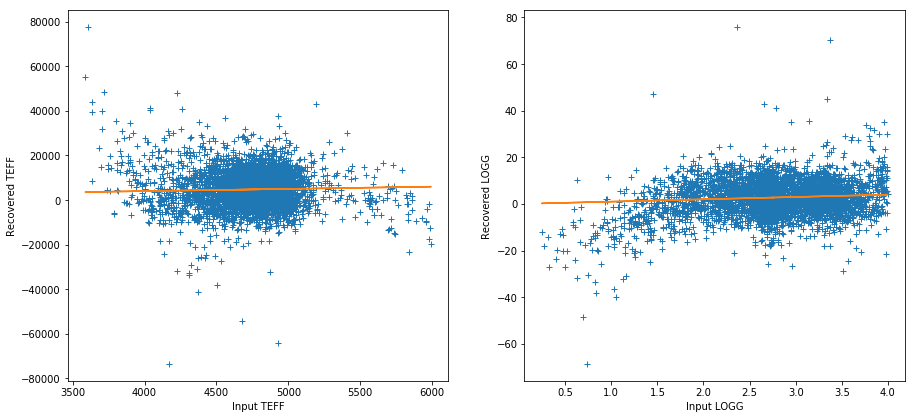

In [38]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
for i in range(0, 2):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    print(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]) )
    

In [32]:
model.vectorizer.label_names

('TEFF', 'LOGG', 'MGH')

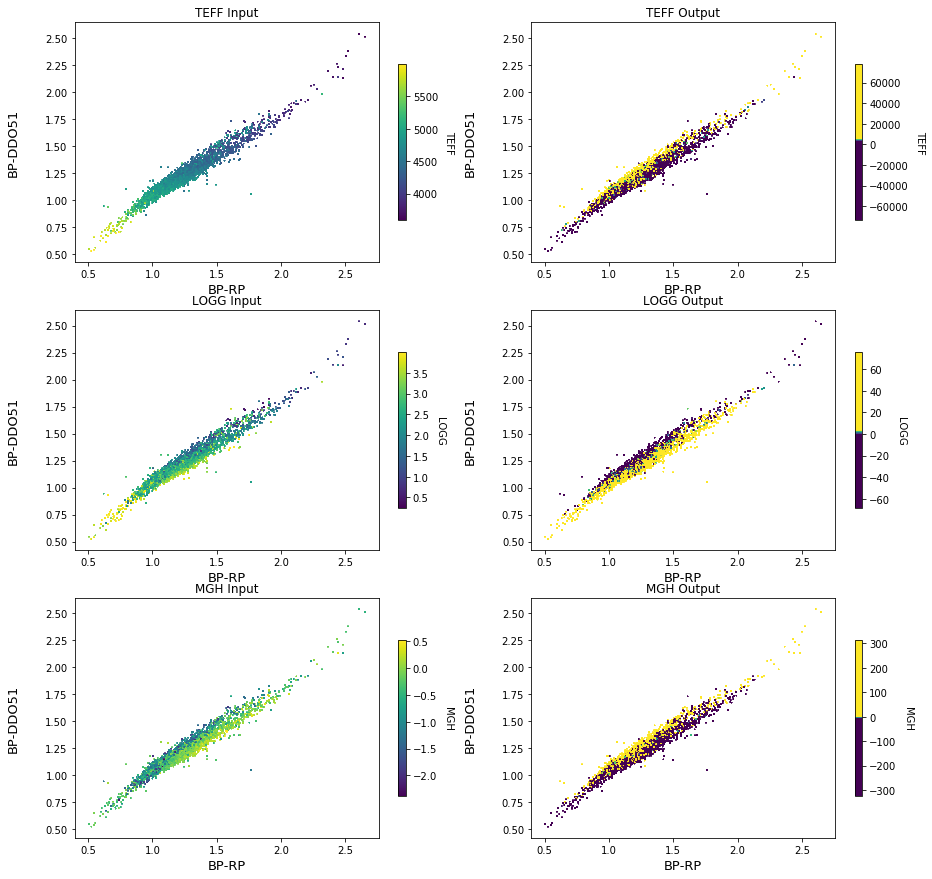

In [34]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

In [83]:
[min(labelled_set[names[0]]),max(labelled_set[names[0]])]

[3587.8999, 5992.6001]

>### More changes to Girardi: Remove log(Teff)>3.778.

In [194]:
# Import functions
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
#Import the calibration data
cat = fits.getdata('WISE_ddo51_isochrone_5e9_range.fits')
labelled_set = Table.read('WISE_ddo51_isochrone_5e9_range.fits')
###labelled_set.info

#Columns to remove from data
#Keep only logg and logTe for now
rmclm = [i for i in labelled_set.colnames if i!= 'logg' and i!= 'logTe']
labelled_set.remove_columns(rmclm)
labelled_set

#Filter out dwarfs
ind = np.where((labelled_set['logg']<3.8) & (labelled_set['logg']>0))
labelled_set = labelled_set[ind]
cat = cat[ind]

#Remove temperatures greater than 6000 K (log(Teff)>3.778)
ind = np.where(labelled_set['logTe']<3.778)
labelled_set = labelled_set[ind]
cat = cat[ind]

num = len(cat)

In [108]:
#Make new array for normalized_flux (photometric data)
#ALLWISE combined with DDO51 photometry
#A typo was made below. I had two instances of W2-W1 instead of having W3-W1.
normalized_flux = np.array([[cat['W2mag'][i]-cat['W1mag'][i],cat['W3mag'][i]-cat['W1mag'][i],cat['DDO51_finfmag'][i]-cat['W1mag'][i]] for i in range(0,num)])

In [109]:
normalized_ivar = normalized_flux.copy()*0 + 1e4
#A 1st order polynomial will be constructed
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

2018-10-02 20:08:05,231 [WARNING] Labels 'logg' and 'logTe' are highly correlated (rho = 0.93). This may cause very slow training times. Are both labels needed?


'1 + logTe + logg'

In [110]:
# Train the model
nr_theta, nr_s2, nr_metadata = model.train()  
# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-02 20:08:39,218 [INFO] Training 2-label CannonModel with 64206 stars and 3 pixels/star
2018-10-02 20:08:39,250 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-02 20:08:39,403 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-02 20:08:39,404 [INFO] Running test step on 64206 spectra


[====================================================================================================] 100% (374s)                                 


logTe bias = 0.005 scatter = 0.023
logg bias = 0.263 scatter = 1.197


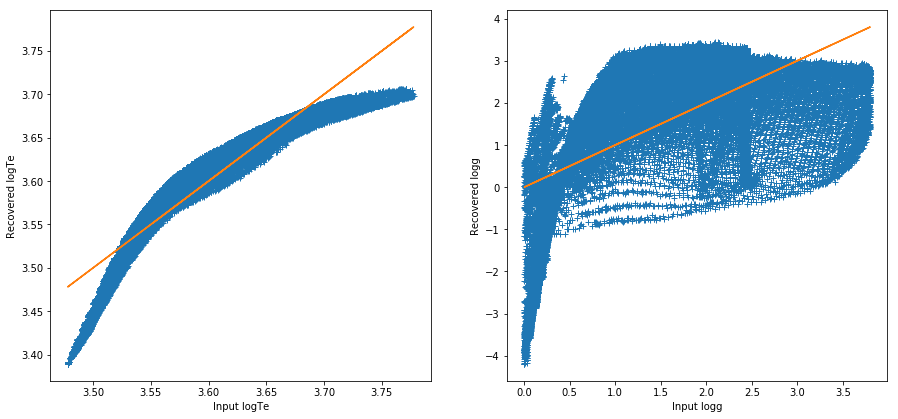

In [111]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
for i in range(0,2):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    print(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]) )
    

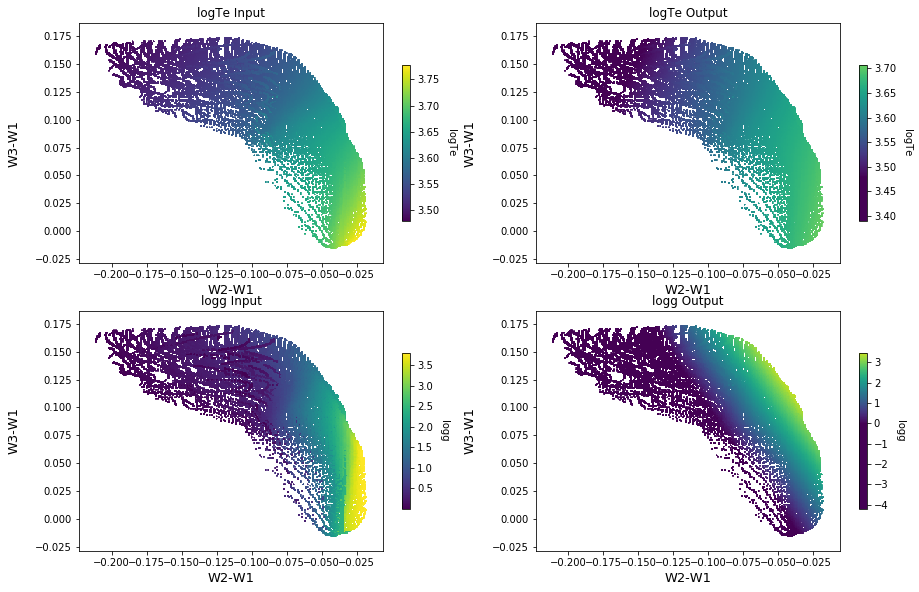

In [114]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,2):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('W2-W1',fontsize=13)
    plt.ylabel('W3-W1',rotation='vertical',labelpad=15,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('W2-W1',fontsize=13)
    plt.ylabel('W3-W1',rotation='vertical',labelpad=15,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

>### Below I determine what is wrong with my photometric errors or inverse variances.  I also changed the colors to:
 - BP-RP
 - BP-DDO51
 - BP-J

In [83]:
# Import libraries and modules
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the calibration data
cat = fits.getdata('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')
labelled_set = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')

#Filter out bad MgH values
ind = np.where(labelled_set['MGH']<10)
labelled_set = labelled_set[ind]
cat = cat[ind]

#columns to remove from data
rmclm = [i for i in labelled_set.colnames if i!= 'MGH' and i!= 'TEFF' and i!= 'LOGG']
labelled_set.remove_columns(rmclm)
num = len(labelled_set)

#Make new array for normalized_flux (photometric data)
normalized_flux = np.array([[cat['BP'][i]-cat['RP'][i],
                             cat['BP'][i]-cat['DDO51'][i],
                             cat['BP'][i]-cat['J'][i]] for i in range(0,num)])
###np.info(normalized_flux)

#Make new array for normalized_flux (photometric data)
#Construct inverse variance for all colors
#TYPO WAS HERE: DIVIDED BY bprp_error ON ALL ivar's
bprp_error = np.sqrt(cat['BPERR']**2+cat['RPERR']**2)
bprp_ivar = 1.0/(bprp_error**2)

bpddo51_error = np.sqrt(cat['BPERR']**2+cat['DDO51_ERR']**2)
bpddo51_ivar = 1.0/(bpddo51_error**2)

bpj_error = np.sqrt(cat['BPERR']**2+cat['J_ERR']**2)
bpj_ivar = 1.0/(bpj_error**2)

normalized_ivar = np.array([[bprp_ivar[i],
                             bpddo51_ivar[i],
                             bpj_ivar[i]] for i in range(0,num)])

In [84]:
#A 1st order polynomial will be constructed
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH'

In [85]:
# TRAIN THE MODEL
nr_theta, nr_s2, nr_metadata = model.train()  

# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-03 00:06:34,108 [INFO] Training 3-label CannonModel with 4397 stars and 3 pixels/star
2018-10-03 00:06:34,148 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-03 00:06:34,246 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-03 00:06:34,248 [INFO] Running test step on 4397 spectra


[======================================================================================================] 100% (34s)                                


TEFF bias = 243.386 scatter = 492.972
LOGG bias = -0.228 scatter = 1.197


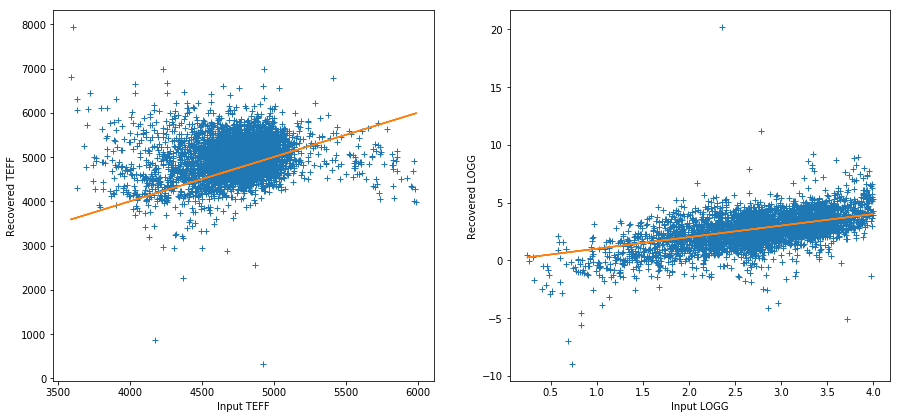

In [86]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
for i in range(0,2):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    print(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]) )
    

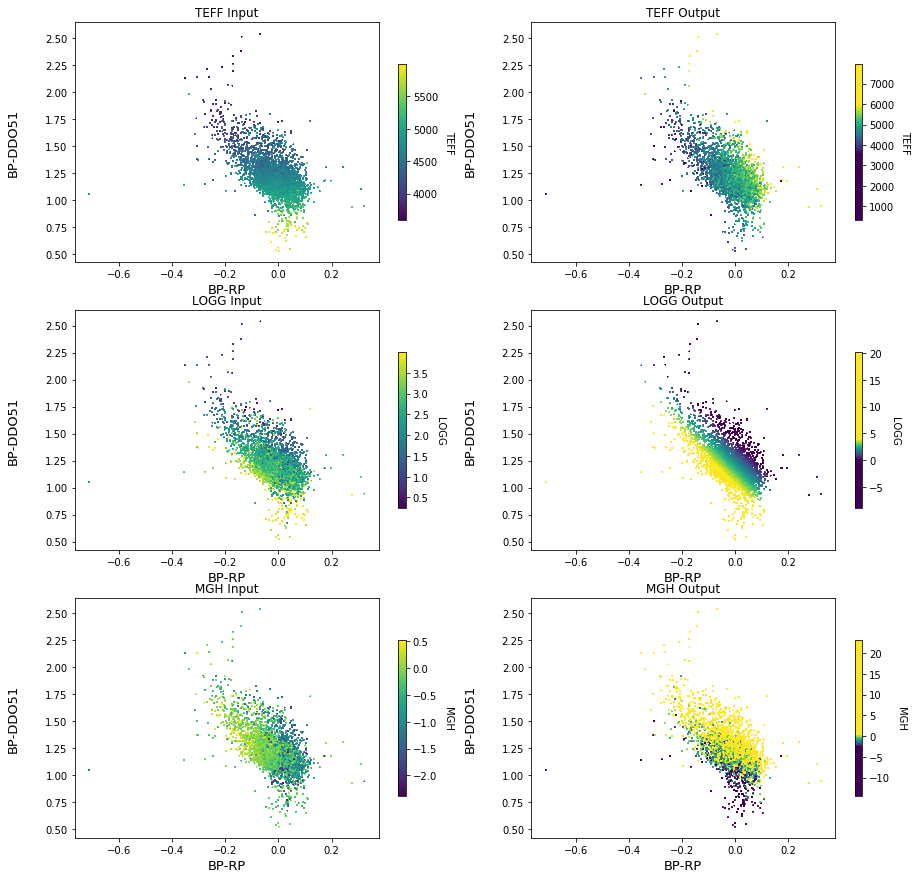

In [79]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

10/5/2018
====

>### David suggested making a "quality cut" in the color errors.

In [38]:
# Import libraries and modules
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the calibration data
cat = fits.getdata('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')
labelled_set = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')

#Filter out bad MgH values
ind = np.where(labelled_set['MGH']<10)
labelled_set = labelled_set[ind]
cat = cat[ind]

#columns to remove from data
rmclm = [i for i in labelled_set.colnames if i!= 'MGH' and i!= 'TEFF' and i!= 'LOGG']
labelled_set.remove_columns(rmclm)
num = len(labelled_set)

#Make new array for normalized_flux (photometric data)
normalized_flux = np.array([[cat['BP'][i]-cat['RP'][i],
                             cat['BP'][i]-cat['DDO51'][i],
                             cat['BP'][i]-cat['J'][i]] for i in range(0,num)])
###np.info(normalized_flux)

#Make new array for normalized_flux (photometric data)
#Construct inverse variance for all colors
#TYPO WAS HERE: DIVIDED BY bprp_error ON ALL ivar's
bprp_error = np.sqrt(cat['BPERR']**2+cat['RPERR']**2)
bprp_ivar = 1.0/(bprp_error**2)

bpddo51_error = np.sqrt(cat['BPERR']**2+cat['DDO51_ERR']**2)
bpddo51_ivar = 1.0/(bpddo51_error**2)

bpj_error = np.sqrt(cat['BPERR']**2+cat['J_ERR']**2)
bpj_ivar = 1.0/(bpj_error**2)

normalized_ivar = np.array([[bprp_ivar[i],
                             bpddo51_ivar[i],
                             bpj_ivar[i]] for i in range(0,num)])

num

4397

In [39]:
#Keep inverse variance greater than 10,000
ind = np.where((bprp_ivar<5e5)&(bpddo51_ivar<5e5)&(bpj_ivar<5e5))
normalized_ivar = normalized_ivar[ind]
normalized_flux = normalized_flux[ind]
labelled_set = labelled_set[ind]
len(normalized_flux)

3446

>### Below I ran the Cannon with 1st order, 2nd order, and 3rd order polynomials.

In [74]:
#A 1st order polynomial
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH'

In [75]:
# TRAIN THE MODEL
nr_theta, nr_s2, nr_metadata = model.train()  

# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-05 13:32:09,519 [INFO] Training 3-label CannonModel with 3446 stars and 3 pixels/star
2018-10-05 13:32:09,571 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-05 13:32:09,636 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-05 13:32:09,639 [INFO] Running test step on 3446 spectra


[=====================================================================================================] 100% (19s)                                


TEFF bias = 248.950 scatter = 559.547
LOGG bias = 0.070 scatter = 0.822
MGH bias = 1.256 scatter = 2.803


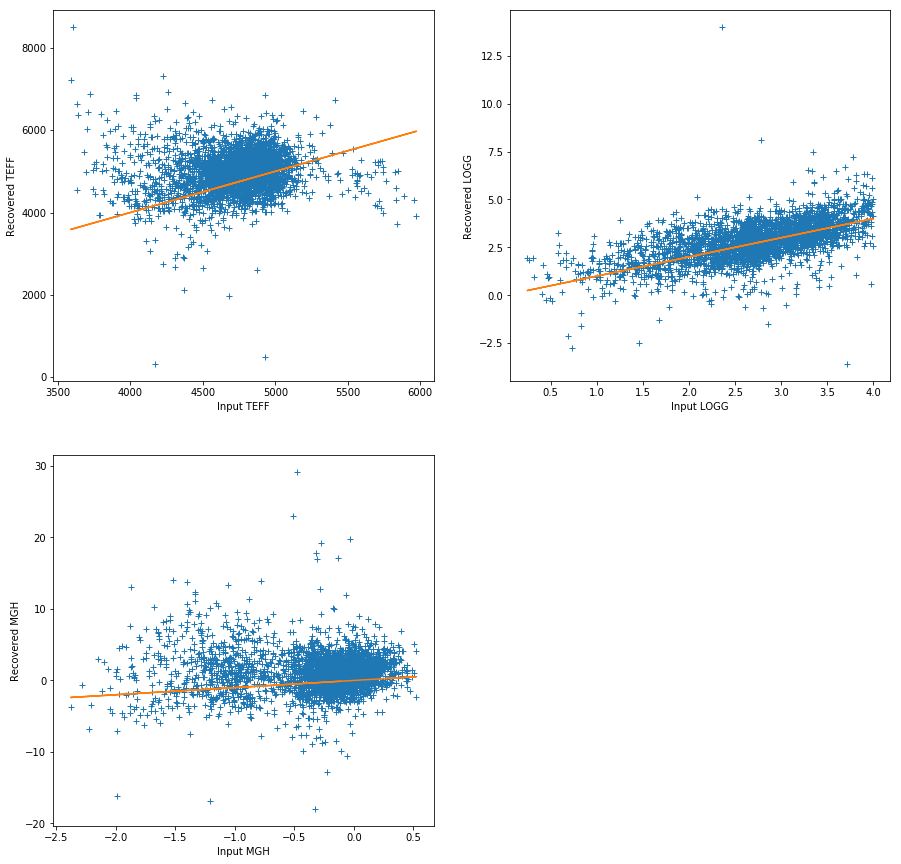

In [76]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
pol1 = []
for i in range(0,3):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    pol1.append(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]))

print(pol1[0])
print(pol1[1])
print(pol1[2])   

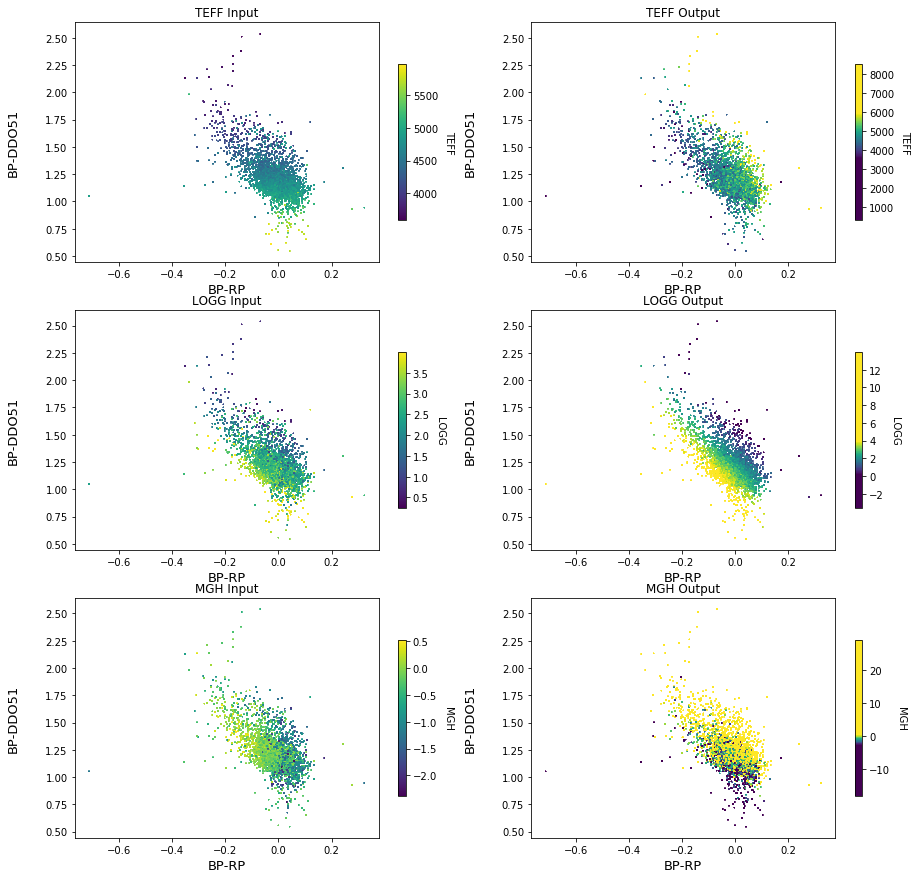

In [55]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

In [77]:
#2nd order polynomial
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 2)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH + TEFF^2 + LOGG*TEFF + MGH*TEFF + LOGG^2 + LOGG*MGH + MGH^2'

In [78]:
# TRAIN THE MODEL
nr_theta, nr_s2, nr_metadata = model.train()  

# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-05 13:32:46,396 [INFO] Training 3-label CannonModel with 3446 stars and 3 pixels/star
2018-10-05 13:32:46,424 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-05 13:32:46,477 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-05 13:32:46,479 [INFO] Running test step on 3446 spectra


[=====================================================================================================] 100% (45s)                                


TEFF bias = 36.326 scatter = 168.462
LOGG bias = -0.031 scatter = 0.702
MGH bias = 0.013 scatter = 0.449


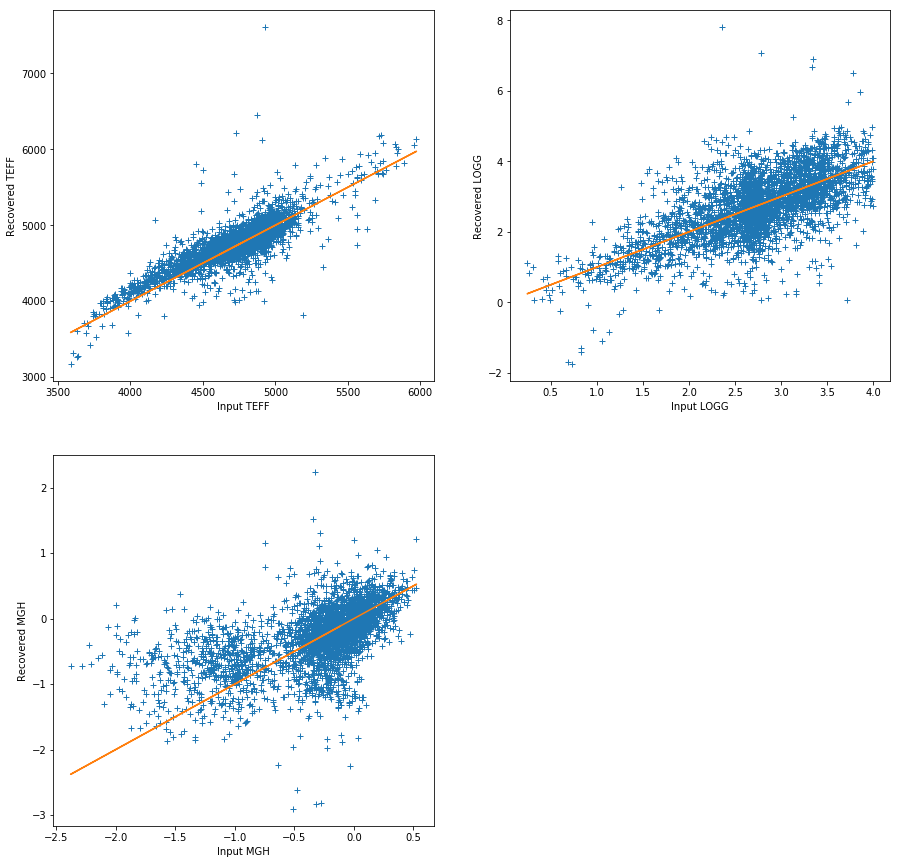

In [79]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
pol2 = []
for i in range(0,3):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    pol2.append(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]))

print(pol2[0])
print(pol2[1])
print(pol2[2])

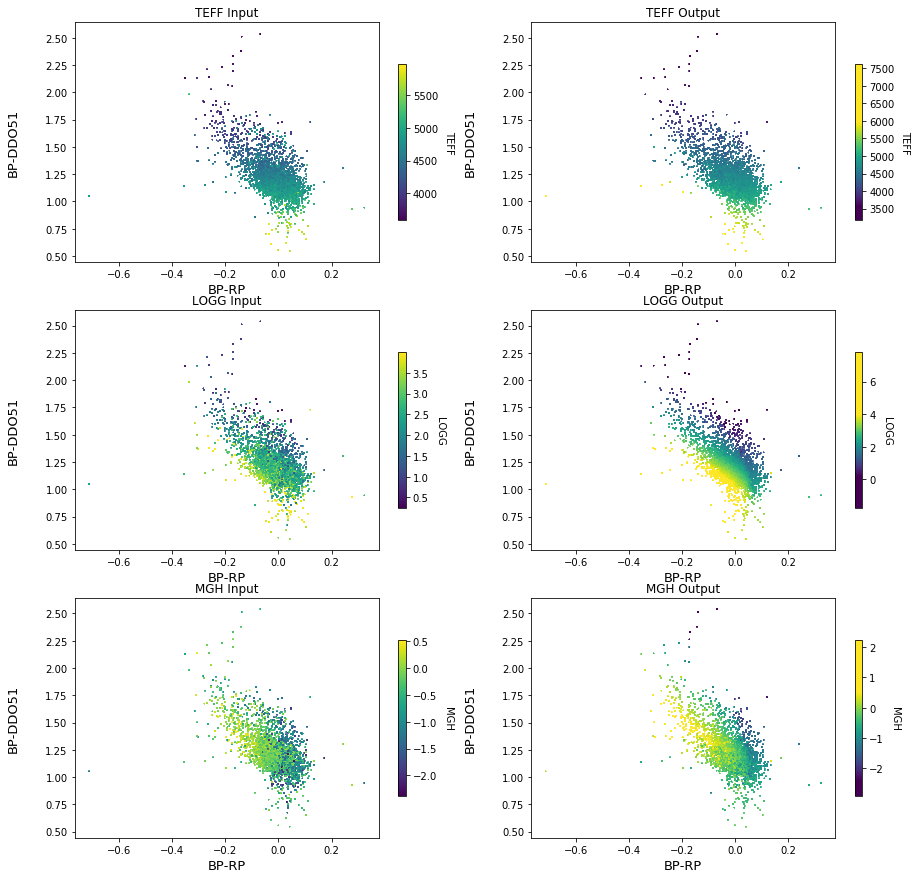

In [59]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

In [80]:
#3rd order polynomial
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 3)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH + TEFF^2 + LOGG*TEFF + MGH*TEFF + LOGG^2 + LOGG*MGH + MGH^2 + TEFF^3 + LOGG*TEFF^2 + MGH*TEFF^2 + LOGG^2*TEFF + LOGG*MGH*TEFF + MGH^2*TEFF + LOGG^3 + LOGG^2*MGH + LOGG*MGH^2 + MGH^3'

In [81]:
# TRAIN THE MODEL
nr_theta, nr_s2, nr_metadata = model.train()  

# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-05 13:34:10,564 [INFO] Training 3-label CannonModel with 3446 stars and 3 pixels/star
2018-10-05 13:34:10,615 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-05 13:34:10,681 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-05 13:34:10,683 [INFO] Running test step on 3446 spectra


[=====================================================================================================] 100% (102s)                               


TEFF bias = 36.741 scatter = 301.191
LOGG bias = 0.150 scatter = 0.821
MGH bias = 0.250 scatter = 0.688


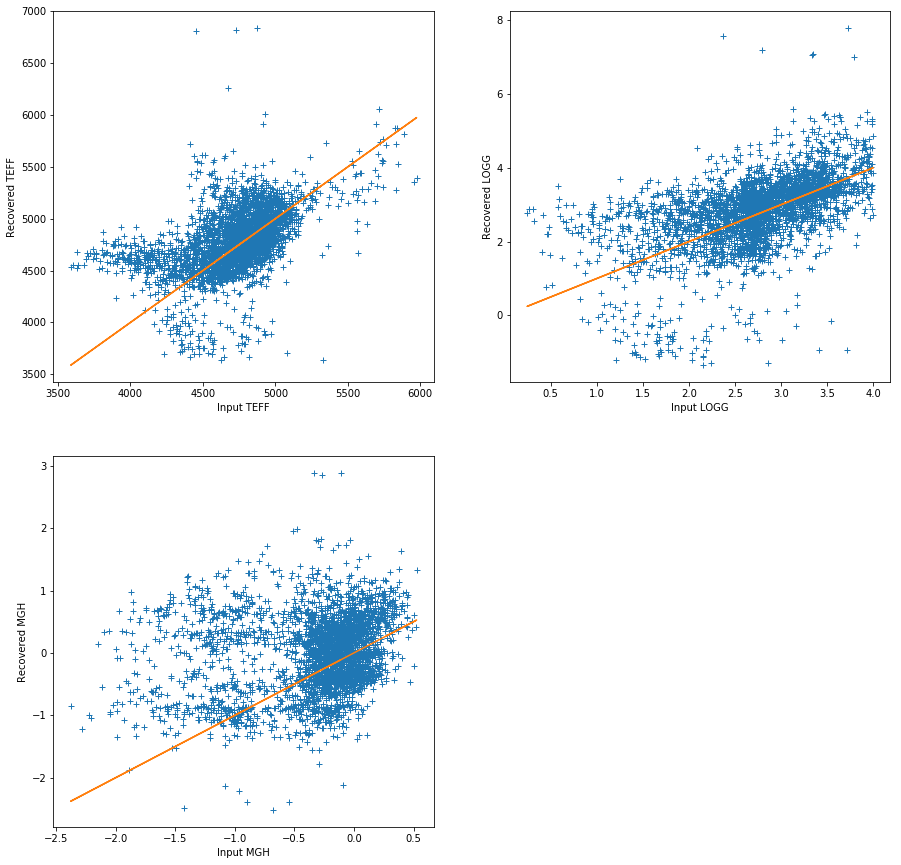

In [82]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
pol3 = []
for i in range(0,3):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    pol3.append(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]))
    
print(pol3[0])
print(pol3[1])
print(pol3[2])

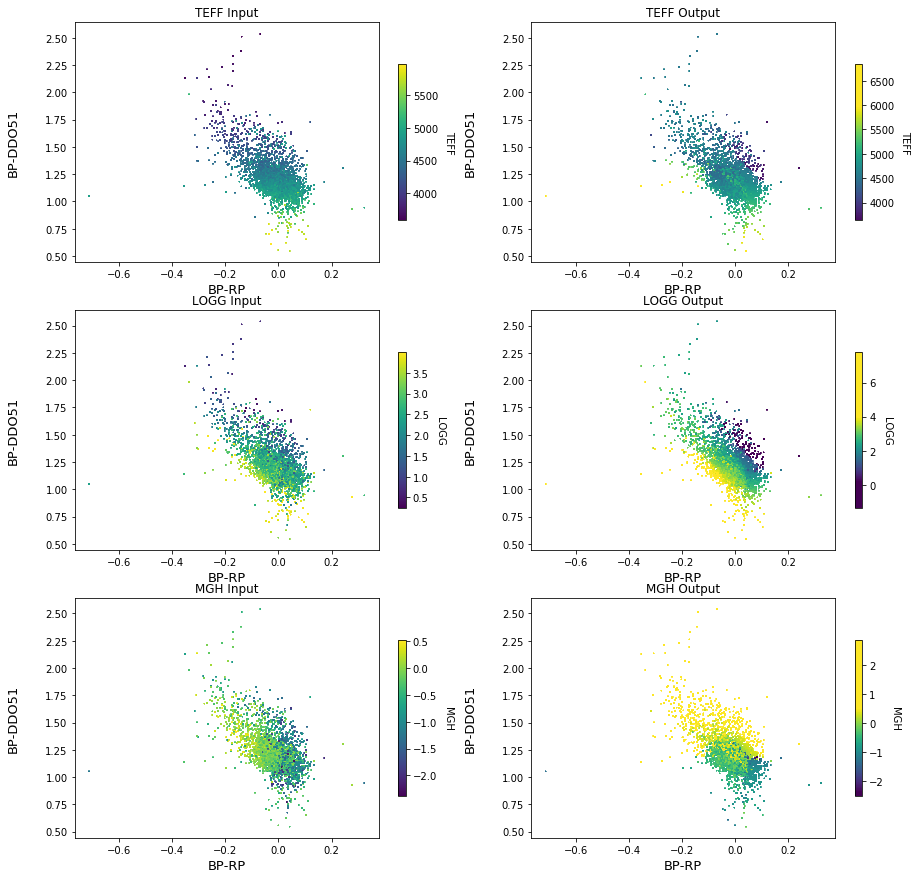

In [63]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

>### Here I compare how all the different trainings went based on the order of polynomial.

In [83]:
print('1st order polynomial:')
print(pol1[0])
print(pol1[1])
print(pol1[2])
print('')
print('2nd order polynomial:')
print(pol2[0])
print(pol2[1])
print(pol2[2])
print('')
print('3rd order polynomial:')
print(pol3[0])
print(pol3[1])

print(pol3[2])

1st order polynomial:
TEFF bias = 248.950 scatter = 559.547
LOGG bias = 0.070 scatter = 0.822
MGH bias = 1.256 scatter = 2.803

2nd order polynomial:
TEFF bias = 36.326 scatter = 168.462
LOGG bias = -0.031 scatter = 0.702
MGH bias = 0.013 scatter = 0.449

3rd order polynomial:
TEFF bias = 36.741 scatter = 301.191
LOGG bias = 0.150 scatter = 0.821
MGH bias = 0.250 scatter = 0.688


>### The output values from the test do not correlate very well with the inputs still.

10/8/2018
====

>### Below I examine S/N ratios and look for aberrant MgH, Teff, and log(g) values in the calibration data.  These could cause poor correlation betwen input and output.

In [19]:
# Import libraries and modules
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the calibration data
cat = fits.getdata('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')
labelled_set = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')

#Filter out bad MgH values
ind = np.where(labelled_set['MGH']<10)
labelled_set = labelled_set[ind]
cat = cat[ind]


217.7073

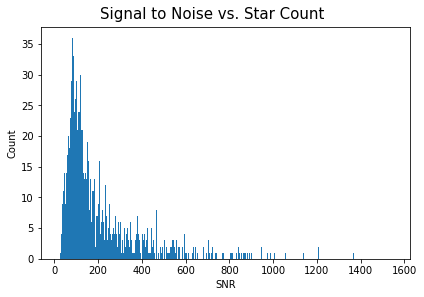

Minimum SNR: 16.838199615478516
Mean SNR: 217.70730590820312


In [49]:
#Plot distribution of signal to noise values vs. counts
plt.hist(cat['SNR'], histtype='bar', range=(16,1551),bins=range(16,1551))
plt.xlabel('SNR')
plt.ylabel('Count')
plt.tight_layout()
plt.suptitle('Signal to Noise vs. Star Count', x=0.5, y=1.02, fontsize = 15)

plt.show()

print("Minimum SNR: {0}".format(min(cat['SNR'])))
print("Mean SNR: {0}".format(np.mean(cat['SNR'])))

In [47]:
print("Max and min MgH: {0}".format([min(cat['MGH']),max(cat['MGH'])]))
print("Max and min Teff: {0}".format([min(cat['TEFF']),max(cat['TEFF'])]))
print("Max and min log(g): {0}".format([min(cat['LOGG']),max(cat['LOGG'])]))

Max and min MgH: [-2.3788433, 0.5257369]
Max and min Teff: [3587.9, 5992.6]
Max and min log(g): [0.24586, 3.9983]
